In [79]:
import pandas as pd
import numpy as np
import os
import kagglehub
from collections import namedtuple
import swifter

from pyproj import Transformer
from shapely import union_all
from shapely.ops import transform
import geopandas as gpd

# Load Wine Reviews

In [80]:
fname = "winemag-data-130k-v2.csv"
path = kagglehub.dataset_download("christopheiv/winemagdata130k")
reviews = pd.read_csv(os.path.join(path, fname), index_col=0)
reviews.info()
location_cols=['winery', 'country', 'province', 'region_1', 'region_2']
reviews[location_cols]

<class 'pandas.core.frame.DataFrame'>
Index: 129971 entries, 0 to 129970
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                129908 non-null  object 
 1   description            129971 non-null  object 
 2   designation            92506 non-null   object 
 3   points                 129971 non-null  int64  
 4   price                  120975 non-null  float64
 5   province               129908 non-null  object 
 6   region_1               108724 non-null  object 
 7   region_2               50511 non-null   object 
 8   taster_name            103727 non-null  object 
 9   taster_twitter_handle  98758 non-null   object 
 10  title                  129971 non-null  object 
 11  variety                129970 non-null  object 
 12  winery                 129971 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 13.9+ MB


,winery,country,province,region_1,region_2
0,Nicosia,Italy,Sicily & Sardinia,Etna,NaN
1,Quinta dos Avidagos,Portugal,Douro,NaN,NaN
2,Rainstorm,US,Oregon,Willamette Valley,Willamette Valley
3,St. Julian,US,Michigan,Lake Michigan Shore,NaN
4,Sweet Cheeks,US,Oregon,Willamette Valley,Willamette Valley
...,...,...,...,...,...
129966,Dr. H. Thanisch (Erben Müller-Burggraef),Germany,Mosel,NaN,NaN
129967,Citation,US,Oregon,Oregon,Oregon Other
129968,Domaine Gresser,France,Alsace,Alsace,NaN
129969,Domaine Marcel Deiss,France,Alsace,Alsace,NaN


**Extract Provinces with Wine Reviews**

In [81]:
reviews.groupby(['country', 'province']).count()[['title']]

title
country   province               
Argentina Mendoza Province   3264
          Other               536
Armenia   Armenia               2
Australia Australia Other     245
          New South Wales      85
...                           ...
Uruguay   Juanico              12
          Montevideo           11
          Progreso             11
          San Jose              3
          Uruguay              24

[425 rows x 1 columns]

In [82]:
reviews[reviews.country.isin(reviews[reviews.province == 'Other'].country.to_list())].groupby(['country', 'province']).count()[['title']]

title
country   province               
Argentina Mendoza Province   3264
          Other               536

In [83]:
# Other regions within Argentina
regions = list(np.unique(reviews[(reviews.country == 'Argentina')&(reviews.province == 'Other')].region_1))
regions.remove('Argentina')
regions

['Alto Valle del Río Negro',
 'Buenos Aires',
 'Cafayate',
 'Calchaquí Valley',
 'Catamarca',
 'Famatina Valley',
 'Jujuy',
 'La Rioja',
 'Neuquén',
 'Patagonia',
 'Pedernal Valley',
 'Río Negro Valley',
 'Salta',
 'San Juan',
 'Tulum Valley',
 'Zonda Valley']

In [84]:
province_names = list(np.unique(reviews.loc[reviews.province.notna(), 'province']))
print('there are reviews from', len(province_names), 'distinct provinces')
province_names.remove('Other')
print('there are reviews from', len(province_names), 'distinct provinces')
province_names += regions
print('there are reviews from', len(province_names), 'distinct provinces')
province_names

there are reviews from 425 distinct provinces
there are reviews from 424 distinct provinces
there are reviews from 440 distinct provinces


['Achaia',
 'Aconcagua Costa',
 'Aconcagua Valley',
 'Aegean',
 'Agioritikos',
 'Ahr',
 'Alenquer',
 'Alentejano',
 'Alentejo',
 'Alenteo',
 'Algarve',
 'Alsace',
 'America',
 'Amindeo',
 'Amyndeon',
 'Andalucia',
 'Ankara',
 'Apalta',
 'Arcadia',
 'Arizona',
 'Armenia',
 'Atalanti Valley',
 'Atlantida',
 'Attica',
 'Australia Other',
 'Austria',
 'Awatere Valley',
 'Baden',
 'Bairrada',
 'Beaujolais',
 'Beira Atlantico',
 'Beira Interior',
 'Beiras',
 'Bekaa Valley',
 'Beotia',
 'Black Sea Coastal',
 'Bordeaux',
 'Bot River',
 'Brazil',
 'Brda',
 'Breede River Valley',
 'Breedekloof',
 'British Columbia',
 'Bucelas',
 'Buin',
 'Bulgaria',
 'Burgenland',
 'Burgundy',
 'Bío Bío Valley',
 'Cachapoal Valley',
 'Cahul',
 'California',
 'Campanha',
 'Canada Other',
 'Canelones',
 'Canterbury',
 'Cape Agulhas',
 'Cape Peninsula',
 'Cape South Coast',
 'Cappadocia',
 'Carnuntum',
 'Casablanca & Leyda Valleys',
 'Casablanca Valley',
 'Casablanca-Curicó Valley',
 'Catalonia',
 'Cauquenes Valley

# Provinces

### Data Source
- [Natural Earth](https://www.naturalearthdata.com/downloads/10m-cultural-vectors/10m-admin-0-details/)

**Load Outlines of Countries In Lat Lon Cartesian Coordinates**

In [85]:
# load the high resolution world map
file = 'data/ne_10m_admin_1_states_provinces/'
columns = [
  # 'featurecla', 'scalerank',
  # 'adm1_code',
  # 'diss_me',
  # 'iso_3166_2',
  # 'wikipedia',
  'iso_a2',
  # 'adm0_sr',
  'name', 'name_alt', 'name_local',
  # 'type', 'type_en', 'code_local', 'code_hasc', 'note', 'hasc_maybe',
  # 'region', 'region_cod', 'provnum_ne', 'gadm_level', 'check_me',
  # 'datarank',
  # 'abbrev',
  # 'postal',
  # 'area_sqkm', 'sameascity',
  # 'labelrank', 'name_len', 'mapcolor9', 'mapcolor13', 'fips',
  # 'fips_alt', 'woe_id', 'woe_label', 
  # 'woe_name', 
  'latitude', 'longitude', 
  # 'sov_a3', 'adm0_a3', 'adm0_label', 
  'admin',
  'geonunit', #'gu_a3', 'gn_id', 'gn_name', 'gns_id', 'gns_name',
  # 'gn_level', 'gn_region', 'gn_a1_code', 'region_sub', 'sub_code',
  # 'gns_level', 
  # 'gns_lang',
  # 'gns_adm1', 'gns_region', 'min_label',
  # 'max_label', 'min_zoom', 'wikidataid', 'name_ar', 'name_bn',
  # 'name_de', 
  'name_en',
  # 'name_es', 'name_fr', 'name_el', 'name_hi',
  # 'name_hu', 'name_id', 'name_it', 'name_ja', 'name_ko', 'name_nl',
  # 'name_pl', 'name_pt', 'name_ru', 'name_sv', 'name_tr', 'name_vi',
  # 'name_zh', 'ne_id', 'name_he', 'name_uk', 'name_ur', 'name_fa',
  # 'name_zht', 'FCLASS_ISO', 'FCLASS_US', 'FCLASS_FR', 'FCLASS_RU',
  # 'FCLASS_ES', 'FCLASS_CN', 'FCLASS_TW', 'FCLASS_IN', 'FCLASS_NP',
  # 'FCLASS_PK', 'FCLASS_DE', 'FCLASS_GB', 'FCLASS_BR', 'FCLASS_IL',
  # 'FCLASS_PS', 'FCLASS_SA', 'FCLASS_EG', 'FCLASS_MA', 'FCLASS_PT',
  # 'FCLASS_AR', 'FCLASS_JP', 'FCLASS_KO', 'FCLASS_VN', 'FCLASS_TR',
  # 'FCLASS_ID', 'FCLASS_PL', 'FCLASS_GR', 'FCLASS_IT', 'FCLASS_NL',
  # 'FCLASS_SE', 'FCLASS_BD', 'FCLASS_UA', 'FCLASS_TLC', 
  'geometry'
]
world = gpd.read_file(file, columns=columns).rename(columns={'iso_a2': 'code', 'latitude': 'lat', 'longitude': 'lon'})
world.info()
world

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4596 entries, 0 to 4595
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   admin       4596 non-null   object  
 1   geonunit    4509 non-null   object  
 2   code        4596 non-null   object  
 3   lat         4596 non-null   float64 
 4   lon         4596 non-null   float64 
 5   name        4589 non-null   object  
 6   name_alt    1980 non-null   object  
 7   name_en     4589 non-null   object  
 8   name_local  430 non-null    object  
 9   geometry    4596 non-null   geometry
dtypes: float64(2), geometry(1), object(7)
memory usage: 359.2+ KB


,admin,geonunit,code,lat,lon,name,name_alt,name_en,name_local,geometry
0,Argentina,Argentina,AR,-32.02750,-59.2824,Entre Ríos,Entre-Rios,Entre Ríos,None,"POLYGON ((-58.20011 -32.44713, -58.20012 -32.4..."
1,Uruguay,Uruguay,UY,-32.09330,-57.2240,Paysandú,None,Paysandú,None,"POLYGON ((-58.20012 -32.4472, -58.20011 -32.44..."
2,Indonesia,Indonesia,ID,1.28915,116.3540,Kalimantan Timur,Kaltim,East Kalimantan,None,"MULTIPOLYGON (((117.70361 4.16341, 117.70361 4..."
3,Malaysia,Malaysia,MY,5.31115,117.0950,Sabah,North Borneo,Sabah,None,"MULTIPOLYGON (((117.70361 4.16341, 117.70361 4..."
4,Chile,Chile,CL,-18.32070,-69.6804,Arica y Parinacota,None,Arica y Parinacota,None,"POLYGON ((-69.51009 -17.50659, -69.50611 -17.5..."
...,...,...,...,...,...,...,...,...,...,...
4591,Malta,Malta,MT,35.88640,14.5149,Isla,Isla|Città Invicta,Senglea,None,"POLYGON ((14.51073 35.88896, 14.51537 35.89113..."
4592,Malta,Malta,MT,35.88000,14.5207,Cospicua,Bormla,Cospicua,None,"POLYGON ((14.52937 35.88156, 14.527 35.87772, ..."
4593,Malta,Malta,MT,35.88910,14.4927,Pietà,None,Pietà,None,"POLYGON ((14.49801 35.89251, 14.49616 35.8883,..."
4594,Malta,Malta,MT,35.89490,14.4825,Msida,None,Msida,None,"POLYGON ((14.48663 35.88636, 14.48231 35.88979..."


**Province Names**

In [86]:
name_columns = list(filter(lambda n: 'name' in n, world.columns))
provinces = world[name_columns]
provinces

,name,name_alt,name_en,name_local
0,Entre Ríos,Entre-Rios,Entre Ríos,None
1,Paysandú,None,Paysandú,None
2,Kalimantan Timur,Kaltim,East Kalimantan,None
3,Sabah,North Borneo,Sabah,None
4,Arica y Parinacota,None,Arica y Parinacota,None
...,...,...,...,...
4591,Isla,Isla|Città Invicta,Senglea,None
4592,Cospicua,Bormla,Cospicua,None
4593,Pietà,None,Pietà,None
4594,Msida,None,Msida,None


**Mercator Projection**

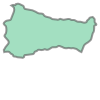

In [87]:
geom=world[world.name == 'Paysandú'].geometry.values[0]
geom

In [88]:
# configure coordinate system transformer - from lat lon to m
transformer = Transformer.from_crs(4326, 3857, always_xy=True)

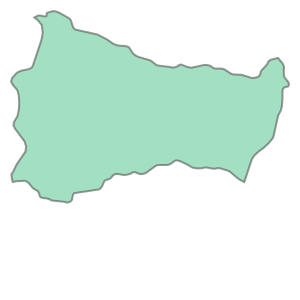

In [89]:
transform(func=transformer.transform, geom=geom)

### Define search boundaries for provinces

In [90]:
BOUNDARY = namedtuple('BOUNDARY', ['geounit', 'admin', 'code', 'geometry', 'area'], defaults=[None]*5)

to_tuple = lambda row: BOUNDARY(
  row.geonunit.values[0],
  row.admin.values[0],
  row.code.values[0],
  row.geometry.values[0],
  transform(func=transformer.transform, geom=row.geometry.values[0]).area,
) if row.shape[0] > 0 else None

**Assign Search Boundaries for Provinces in the Wine Review Dataset**

In [91]:
# use a dict for fast performance, small data set.
provinces = {
  province: to_tuple(world[world.name == province])
  for province in province_names
  if to_tuple(world[world.name == province])
}

provinces

{'Ankara': BOUNDARY(geounit='Turkey', admin='Turkey', code='TR', geometry=<POLYGON ((32.315 40.415, 32.396 40.448, 32.424 40.486, 32.459 40.516, 32.47...>, area=43550256916.04473),
 'Arizona': BOUNDARY(geounit='United States of America', admin='United States of America', code='US', geometry=<POLYGON ((-111.006 31.327, -111.067 31.334, -111.094 31.343, -111.146 31.35...>, area=433821815136.92737),
 'Brda': BOUNDARY(geounit='Slovenia', admin='Slovenia', code='SI', geometry=<POLYGON ((13.462 46.006, 13.477 46.016, 13.482 46.018, 13.49 46.026, 13.493...>, area=173143827.22089887),
 'British Columbia': BOUNDARY(geounit='Canada', admin='Canada', code='CA', geometry=<MULTIPOLYGON (((-117.038 48.993, -117.158 48.993, -117.378 48.993, -117.598...>, area=2863355161895.8843),
 'Burgenland': BOUNDARY(geounit='Austria', admin='Austria', code='AT', geometry=<POLYGON ((17.148 48.005, 17.086 47.97, 17.096 47.962, 17.096 47.956, 17.091...>, area=8737366429.652283),
 'Cahul': BOUNDARY(geounit='Moldova',

<Axes: >

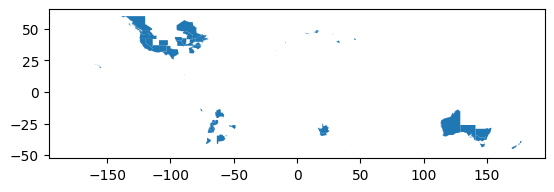

In [92]:
# Provinces
gpd.GeoSeries(list(map(lambda country: country.geometry, provinces.values()))).plot()

### Augment the reviews with the corresponding search boundaries

In [93]:
reviews.loc[reviews.country.notna()&reviews.province.isin(provinces), 'geometry'] = reviews[reviews.country.notna()&reviews.province.isin(provinces)].province.swifter.apply(lambda province: provinces[province].geometry)
reviews.loc[reviews.country.notna()&reviews.province.isin(provinces), 'area'] = reviews[reviews.country.notna()&reviews.province.isin(provinces)].province.swifter.apply(lambda province: provinces[province].area)
greviews = gpd.GeoDataFrame(reviews, geometry='geometry')
greviews.info()
greviews

Pandas Apply:   0%|          | 0/59224 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/59224 [00:00<?, ?it/s]

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 129971 entries, 0 to 129970
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   country                129908 non-null  object  
 1   description            129971 non-null  object  
 2   designation            92506 non-null   object  
 3   points                 129971 non-null  int64   
 4   price                  120975 non-null  float64 
 5   province               129908 non-null  object  
 6   region_1               108724 non-null  object  
 7   region_2               50511 non-null   object  
 8   taster_name            103727 non-null  object  
 9   taster_twitter_handle  98758 non-null   object  
 10  title                  129971 non-null  object  
 11  variety                129970 non-null  object  
 12  winery                 129971 non-null  object  
 13  geometry               59224 non-null   geometry
 14  area             

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,geometry,area
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,None,NaN
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,None,NaN
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,"MULTIPOLYGON (((-124.49245 42.92984, -124.4636...",4.863020e+11
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,"POLYGON ((-89.49896 47.99509, -89.46185 47.994...",4.988727e+11
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,"MULTIPOLYGON (((-124.49245 42.92984, -124.4636...",4.863020e+11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129966,Germany,Notes of honeysuckle and cantaloupe sweeten th...,Brauneberger Juffer-Sonnenuhr Spätlese,90,28.0,Mosel,NaN,NaN,Anna Lee C. Iijima,NaN,Dr. H. Thanisch (Erben Müller-Burggraef) 2013 ...,Riesling,Dr. H. Thanisch (Erben Müller-Burggraef),None,NaN
129967,US,Citation is given as much as a decade of bottl...,NaN,90,75.0,Oregon,Oregon,Oregon Other,Paul Gregutt,@paulgwine,Citation 2004 Pinot Noir (Oregon),Pinot Noir,Citation,"MULTIPOLYGON (((-124.49245 42.92984, -124.4636...",4.863020e+11
129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser,None,NaN
129969,France,"A dry style of Pinot Gris, this is crisp with ...",NaN,90,32.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Domaine Marcel Deiss 2012 Pinot Gris (Alsace),Pinot Gris,Domaine Marcel Deiss,None,NaN


In [94]:
reviews[reviews.geometry.notna()].groupby(['country', 'province']).count()[['title']].sort_values('title', ascending=False)

title
country      province                
US           California         36247
             Washington          8639
             Oregon              5373
             New York            2688
Australia    South Australia     1349
US           Virginia             777
Austria      Burgenland           672
             Niederösterreich     600
Portugal     Lisboa               506
Australia    Victoria             322
             Western Australia    286
South Africa Western Cape         281
US           Idaho                192
Canada       British Columbia     160
New Zealand  Hawke's Bay          136
US           Michigan             114
Canada       Ontario               96
US           Texas                 94
Australia    New South Wales       85
Georgia      Kakheti               73
US           Colorado              68
             New Mexico            45
Uruguay      Canelones             43
Australia    Tasmania              42
US           Arizona               41
             Missouri              33
South Africa Wellington            23
US           North Carolina        23
Austria      Steiermark            20
US           Pennsylvania          18
Turkey       Ankara                18
Peru         Ica                   16
Portugal     Madeira               13
Georgia      Georgia               13
Hungary      Eger                  13
New Zealand  Canterbury            12
US           Ohio                  12
Uruguay      Montevideo            11
US           New Jersey             8
             Massachusetts          7
Slovenia     Brda                   7
Chile        Santa Cruz             6
US           Illinois               6
             Iowa                   4
Hungary      Sopron                 4
US           Nevada                 4
             Vermont                3
Moldova      Cahul                  3
US           Connecticut            3
Hungary      Szekszárd              2
Brazil       Santa Catarina         2
South Africa Northern Cape          2
Mexico       San Vicente            2
Switzerland  Valais                 2
             Neuchâtel              1
US           Kentucky               1
             Hawaii                 1
Switzerland  Ticino                 1
US           Rhode Island           1

## Match `Region_1` fields

In [95]:
reviews.groupby(['country', 'region_1']).count()[['title']].sort_values('title', ascending=False)

title
country   region_1                                   
US        Napa Valley                            4480
          Columbia Valley (WA)                   4124
          Russian River Valley                   3091
          California                             2629
          Paso Robles                            2350
...                                               ...
France    Vin de Pays des Coteaux de Bessilles      1
Argentina Medrano                                   1
          Jujuy                                     1
          Altos de Mendoza                          1
          Catamarca                                 1

[1230 rows x 1 columns]

In [96]:
region_names = np.unique(reviews[reviews.region_1.notna()].region_1.to_list() + reviews[reviews.region_2.notna()].region_2.to_list()).tolist()
region_names

['Abruzzo',
 'Adelaida District',
 'Adelaide',
 'Adelaide Hills',
 'Adelaide Plains',
 "Aglianico d'Irpinia",
 'Aglianico del Beneventano',
 'Aglianico del Taburno',
 'Aglianico del Vulture',
 'Agrelo',
 'Albana di Romagna',
 'Alcamo',
 "Aleatico dell'Elba",
 'Alella',
 'Alexander Valley',
 'Alghero',
 'Alicante',
 'Almansa',
 'Aloxe-Corton',
 'Alpilles',
 'Alpine Valleys',
 'Alsace',
 'Alta Langa',
 'Alta Mesa',
 'Alta Valle della Greve',
 'Alto Adige',
 'Alto Adige Terlano',
 'Alto Adige Valle Isarco',
 'Alto Valle del Río Negro',
 'Altos de Mendoza',
 'Amador County',
 'Amador-Napa',
 'Amarone della Valpolicella',
 'Amarone della Valpolicella Classico',
 'Amarone della Valpolicella Valpantena',
 'Ancient Lakes',
 'Anderson Valley',
 'Anjou',
 'Anjou Villages',
 'Anjou Villages Brissac',
 'Antelope Valley of the California High Desert',
 'Applegate Valley',
 'Apremont',
 'Arbois',
 'Ardèche',
 'Argentina',
 'Arizona',
 'Arribes del Duero',
 'Arroyo Grande Valley',
 'Arroyo Seco',
 'A

In [97]:
# use a dict for fast performance, small data set.
regions = {
  region: to_tuple(world[world.name == region])
  for region in region_names
  if to_tuple(world[world.name == region])
}

regions

{'Alicante': BOUNDARY(geounit=None, admin='Spain', code='ES', geometry=<POLYGON ((-0.031 38.883, -0.01 38.87, 0.017 38.864, 0.063 38.861, 0.111 38....>, area=9491896215.347948),
 'Ardèche': BOUNDARY(geounit='France', admin='France', code='FR', geometry=<POLYGON ((4.811 45.296, 4.811 45.279, 4.817 45.279, 4.813 45.26, 4.812 45.2...>, area=11229158610.716589),
 'Arizona': BOUNDARY(geounit='United States of America', admin='United States of America', code='US', geometry=<POLYGON ((-111.006 31.327, -111.067 31.334, -111.094 31.343, -111.146 31.35...>, area=433821815136.92737),
 'Asti': BOUNDARY(geounit='Italy', admin='Italy', code='IT', geometry=<POLYGON ((8.024 44.806, 8.005 44.81, 7.993 44.821, 7.984 44.838, 7.974 44.8...>, area=3040521640.6141863),
 'Atlantique': BOUNDARY(geounit='Benin', admin='Benin', code='BJ', geometry=<POLYGON ((2.36 6.336, 2.307 6.331, 2.227 6.314, 1.988 6.287, 1.988 6.287, 1...>, area=3200656886.7323623),
 'Brindisi': BOUNDARY(geounit='Italy', admin='Italy', code

In [98]:
reviews.loc[reviews.geometry.notna()&(reviews.region_1.isin(regions)), 'geometry'] = reviews.loc[reviews.geometry.notna()&(reviews.region_1.isin(regions))].region_1.swifter.apply(lambda region: regions[region].geometry)
reviews.info()

Pandas Apply:   0%|          | 0/5755 [00:00<?, ?it/s]

<class 'pandas.core.frame.DataFrame'>
Index: 129971 entries, 0 to 129970
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                129908 non-null  object 
 1   description            129971 non-null  object 
 2   designation            92506 non-null   object 
 3   points                 129971 non-null  int64  
 4   price                  120975 non-null  float64
 5   province               129908 non-null  object 
 6   region_1               108724 non-null  object 
 7   region_2               50511 non-null   object 
 8   taster_name            103727 non-null  object 
 9   taster_twitter_handle  98758 non-null   object 
 10  title                  129971 non-null  object 
 11  variety                129970 non-null  object 
 12  winery                 129971 non-null  object 
 13  geometry               59224 non-null   object 
 14  area                   59224 non-null   f